### Import thư viện và dataset

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import math
from tensorflow.keras import layers, models

 
path = "Datasetnew" 
labelFile = 'labelsnew.csv' 

c_model_name = 'bbgt_model'
tflite_model_name = 'bbgt_model'

batch_size_val=32 
epochs_val=6
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2 

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Tổng số nhãn được phát hiện:",len(myList))
noOfClasses=len(myList)
print("Đang khởi tạo.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)
 
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 

print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

Tổng số nhãn được phát hiện: 3
Đang khởi tạo.....
0 1 2  
Data Shapes
Train(3360, 32, 32, 3) (3360,)
Validation(840, 32, 32, 3) (840,)
Test(1050, 32, 32, 3) (1050,)
data shape  (3, 2) <class 'pandas.core.frame.DataFrame'>


### Kiểm tra dataset

[1237, 1260, 863]


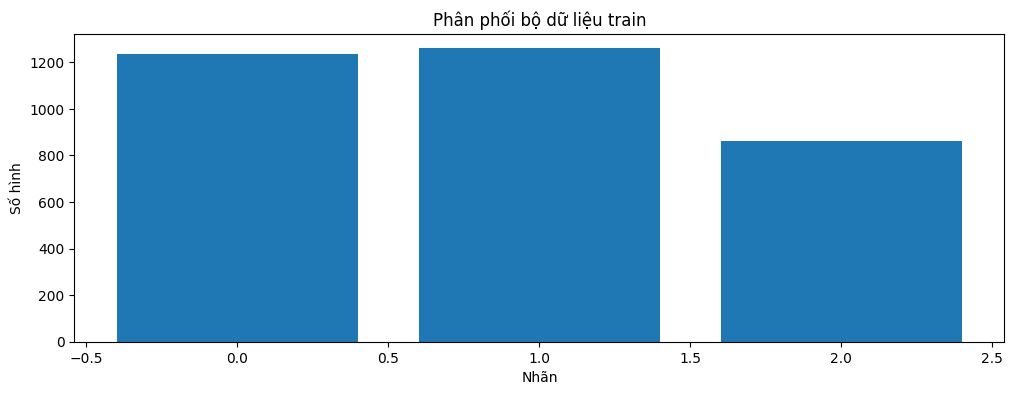

In [170]:
#Hiển thị phân phối số hình trong từng nhãn
num_of_samples = []
cols = 5
num_classes = noOfClasses

for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    num_of_samples.append(len(x_selected))

#Biểu đồ phân phối
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Phân phối bộ dữ liệu train")
plt.xlabel("Nhãn")
plt.ylabel("Số hình")
plt.show()

### Tiền xử lý

In [171]:

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     
    img = equalize(img)      
    img = img/255            
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))


X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
 
 
dataGen= ImageDataGenerator(width_shift_range=0.1,   
                            height_shift_range=0.1,
                            zoom_range=0.2,  
                            shear_range=0.1,  
                            rotation_range=10)  
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)
 

y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

### Train model

In [172]:
# def myModel():
#     model= Sequential()
#     model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))
#     model.add((Conv2D(60, (5,5), activation='relu')))
#     model.add(MaxPooling2D(pool_size=(2,2)))
 
#     model.add((Conv2D(30, (3,3),activation='relu')))
#     model.add((Conv2D(30, (3,3), activation='relu')))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.5))
 
#     model.add(Flatten())
#     model.add(Dense(500,activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(noOfClasses,activation='softmax')) 
#     model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
#     return model

In [173]:
model = tf.keras.Sequential()
model.add((Conv2D(6,(3,3),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add((Conv2D(6, (3,3), activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(15,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(noOfClasses,activation='softmax')) 
model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 30, 30, 6)         60        
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 15, 15, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 13, 13, 6)         330       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 6, 6, 6)           0         
 ng2D)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 6, 6, 6)           0         
                                                                 
 flatten_19 (Flatten)        (None, 216)             

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3368\670793618.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)


105/105 [==============================] - 3s 19ms/step - loss: 1.0884 - accuracy: 0.3878 - val_loss: 1.0041 - val_accuracy: 0.6488
Epoch 2/6
105/105 [==============================] - 1s 14ms/step - loss: 1.0104 - accuracy: 0.4893 - val_loss: 0.7835 - val_accuracy: 0.9167
Epoch 3/6
105/105 [==============================] - 1s 14ms/step - loss: 0.8580 - accuracy: 0.6119 - val_loss: 0.4741 - val_accuracy: 0.9631
Epoch 4/6
105/105 [==============================] - 1s 14ms/step - loss: 0.6809 - accuracy: 0.7146 - val_loss: 0.2308 - val_accuracy: 0.9881
Epoch 5/6
105/105 [==============================] - 1s 14ms/step - loss: 0.5578 - accuracy: 0.7857 - val_loss: 0.1299 - val_accuracy: 0.9845
Epoch 6/6
105/105 [==============================] - 2s 15ms/step - loss: 0.4500 - accuracy: 0.8259 - val_loss: 0.0750 - val_accuracy: 0.9952


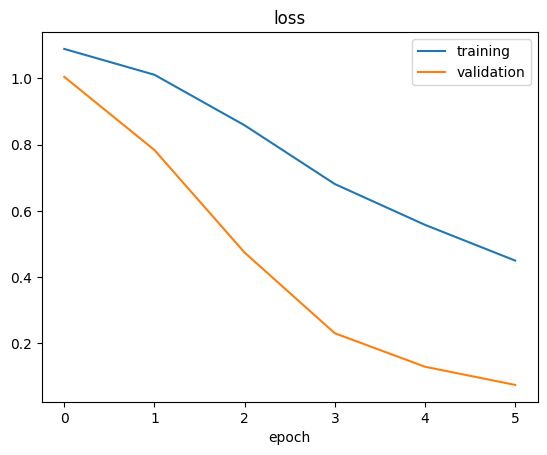

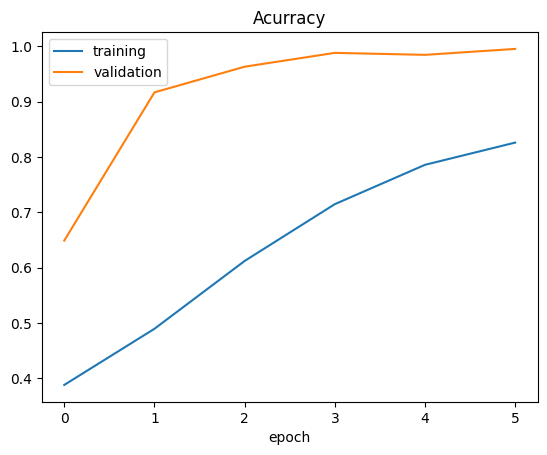

Test Score: 0.067270427942276
Test Accuracy: 0.9971428513526917


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [174]:
# model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 
model.save("model.h5")

In [175]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_4xwd_9l\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_4xwd_9l\assets


18340

In [176]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [177]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))